In [279]:
"""Cell:Utility"""
import numpy as np
from scipy import pi
from matplotlib import pyplot as plt
def np_concatenate(x_array):
    """Returns np array corresponding to the cocatenation of all the np arrays in x_array"""
    z = []
    for cur_array in x_array:
        for i in range(len(cur_array)):
            z.append(cur_array[i])   
    z = np.array(z)
    return z
    
    
def get_max_range(x, tolerance):
    """Returns the indices and values for all values >= tolerance*maximum"""
    max_indices = []
    max_values = [] 
    max_value = max(x)

    for k,elem in enumerate(x):
        if elem >= tolerance*max_value:
            max_values.append(elem)
            max_indices.append(k)

    return [max_indices, max_values] 


def complex_dot(x, y):
    """Returns dot product of x with conjugate of y (inner product of x and y)"""
    if len(x) != len(y):
        raise ValueError("Input vectors need to be of same size but size x is " + str(len(x)) + " while size y is " + str(len(y)))
    else:     
        dot_xy = sum(x[i]*np.conj(y[i]) for i in range(len(x)))
        return dot_xy


def complex_correlation(x, y):    
    """Returns complex correlation (between -1 and 1 of the vectors x,y)"""
    if len(x) != len(y):
        raise ValueError("Input vectors need to be of same size but size x is " + str(len(x)) + " while size y is " + str(len(y)))
    else:
        correlation_xy = complex_dot(x,y)/np.sqrt(complex_dot(x,x)*(complex_dot(y,y)))
        return (correlation_xy)

def correlate(x, y): 
    '''Returns x.y/sqrt(x.x*y.y) '''
    if(len(x) == len(y)):
        num = np.sum(np.multiply(x,y))
        den = np.sqrt(np.sum(np.multiply(x,x))*np.sum(np.multiply(y,y)))
        if den is not 0:
            return num/den
        else:
            return 1
    else:
        raise ValueError("Length of x = " + str(len(x)) + " does not match length of  y = "  + str(len(y)))  
        
def to_scale(x, scale =1):
    x = np.array(x)
    y = scale*x/max(abs(x))
    return y

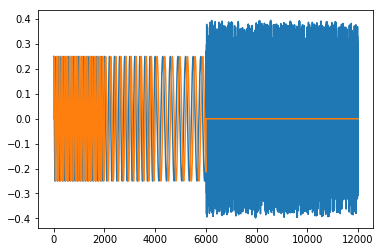

5000.0 200
2500.0 2200
1666.6666666666667 4200


In [280]:
"""Cell:Complex input"""
len_tone = 2000

data_to_tone_ratio  = 1
sampling_frequency = 500e3
input_multiply_constant = 0.25

tone_frequencies = [ sampling_frequency/100.0, sampling_frequency/200.0, sampling_frequency/300.0] 
len_data = len(tone_frequencies)*len_tone*data_to_tone_ratio
tone_margin = 0.1
correlation_dict = {}
file_source_complex_expt2  = "./logs/fileSourceComplexExpt2"

def get_complex_data():
    '''Returns complex values corresponding to input read from file sink of expt 1 '''    
    complex_data = np.fromfile(file_source_complex_expt2, dtype = 'complex64')
#     print(len_data)
    complex_data = complex_data[len_tone*len(tone_frequencies):len_tone*len(tone_frequencies) +len_data]
    return complex_data

def get_complex_tones():
    """Returns complex values corresponding to input sine tones """
   
    y = []
    x = np.array(range(len_tone))
    for k,tone_frequency in enumerate(tone_frequencies):
        cur_start = k*len_tone     
        y_temp = np.array(np.exp(x*2.0j*pi*tone_frequency/sampling_frequency))
        correlation_dict[tone_frequency] = {}
        correlation_dict[tone_frequency]['start'] = cur_start + int(len_tone*tone_margin)
        correlation_dict[tone_frequency]['wave'] = y_temp[int(len_tone*tone_margin):int(len_tone*(1 - tone_margin))]
        for i in range(len(y_temp)):
            y.append(y_temp[i])

    complex_tones = np.array(y, dtype = 'complex64')   
    return complex_tones


def get_complex_input():
       
    complex_tones = get_complex_tones()
    complex_data = get_complex_data()
    complex_input = input_multiply_constant*np.concatenate([complex_tones,complex_data] , axis = 0)
    return complex_input

complex_input = get_complex_input()
plt.plot(complex_input.real)
plt.plot(complex_input.imag)
plt.show()
for key in correlation_dict:
    print(key, correlation_dict[key]['start'])

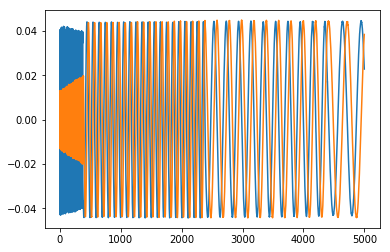

In [286]:
"""Cell:Complex output"""
file_sink_complex_expt2  = "./logs/fileSinkComplexExpt2_2"
def read_output():  
    """Reads the complex values from output file sink generated by gnuradio expt 2"""
    
    complex_output = np.fromfile(file_sink_complex_expt2, dtype = 'complex64').reshape(-1,1)  
    plt.plot(complex_output[11:18000].real)
    plt.plot(complex_output[11:18000].imag)
    plt.show()
    
    return complex_output
    
complex_output = read_output()


In [282]:
"""Cell:Output segmentation"""

"""
    Segments the output stream into [tones + data ] windows based on coarse lag estimates
    Returns a list of tuples [start, np.array(y)]
    start:the sample in output stream where the current window starts
    
"""

data_to_tone_ratio  = 1
len_data = len(tone_frequencies)*len_tone*data_to_tone_ratio
max_lag_end = len(tone_frequencies)*(len_tone*2) + len_data
min_lag_start = 0
max_tolerance_threshold = 0.99
lag_jump = 5
len_window = len(tone_frequencies)*(len_tone) + len_data #Since equal length of tones to data

def get_lag_estimate(complex_output):
    '''Returns best lag estimate based on coarse timing synchronization using tones'''
   
    lag_start = min_lag_start;
    lag_est_array = []
    for tone_frequency in tone_frequencies:
        start = correlation_dict[tone_frequency]['start']
        cur_x = correlation_dict[tone_frequency]['wave']
        print ('Correlating for wave starting at ' + str(start) + '...')
     
        lag_end = min(max_lag_end, len(complex_output) - len(cur_x) )


        corr_array = []
        lag_array = []
        for lag in np.arange(lag_start, lag_end+1, lag_jump):
            cur_y = complex_output[lag:lag+len(cur_x), 0]

            cur_corr = correlate(abs(cur_x.real), abs(cur_y.real))
            corr_array.append(cur_corr)
            lag_array.append(lag)
            # print ('Lag: ' + str(lag) + ', Corr: ' + str(cur_corr))

        [max_indices, max_range] = get_max_range(corr_array, tolerance=max_tolerance_threshold)
        
        cur_lag_array = []
        for index in max_indices:
            cur_lag_array.append(lag_array[index])

        print('---Max Lags')
        print('---' + str(cur_lag_array))
        print('---Max Values')
        print('---'+ str(max_range))

        # cur_est_lag = cur_lag_array[len(cur_lag_array)//2] - start 
        cur_est_lag = cur_lag_array[len(cur_lag_array)-1] - start 

        print('---Current Estimated Lag: ' + str(cur_est_lag))
        lag_est_array.append(cur_est_lag)
  
    lag_estimate = lag_est_array[len(lag_est_array)//2]
    print('Final estimated lag: ' + str(lag_estimate))
    
    return lag_estimate


def get_distorted_output_array(complex_output):
    coarse_lag_estimate = get_lag_estimate(complex_output)

    window_start = coarse_lag_estimate
    window_end = window_start + len_window
    max_windows = float('inf')
    cur_num_window = 0

    distorted_output_array = []

    while window_end < len(complex_output) and cur_num_window < max_windows:
        cur_y = complex_output[window_start:window_end]
        distorted_output_array.append([window_start, cur_y])   
        window_start += len_window
        window_end =  window_start + len_window
        cur_num_window += 1
    
    print("Total of " + str(len(distorted_output_array)) + " windows ")
    return distorted_output_array
    
distorted_output_array = get_distorted_output_array(complex_output)

Correlating for wave starting at 200...
---Max Lags
---[7350, 7400, 7450, 7500, 7550, 7600, 7650, 7700, 7750, 7800]
---Max Values
---[0.97658656925205267, 0.98103590720640055, 0.9820014949849849, 0.98265336998741282, 0.98291727339580393, 0.98287452934832142, 0.98246374844533357, 0.98173799642133075, 0.98063263452276206, 0.97833781544035481]
---Current Estimated Lag: 7600
Correlating for wave starting at 2200...
---Max Lags
---[9235, 9335, 9340, 9435, 9440, 9535, 9540, 9640, 9645, 9740, 9745, 9845]
---Max Values
---[0.97430770885393658, 0.98049309738576162, 0.98182047522469529, 0.97930551647969377, 0.98268277307522445, 0.9756735762199289, 0.98401505019094349, 0.98331298654371579, 0.97768202616618771, 0.9818750079482288, 0.98126231757987825, 0.97752498846924929]
---Current Estimated Lag: 7645
Correlating for wave starting at 4200...
---Max Lags
---[11250, 11255, 11400, 11405, 11410, 11550, 11555, 11560, 11705, 11710, 11715, 11855, 11860, 11865]
---Max Values
---[0.97405540501356036, 0.97

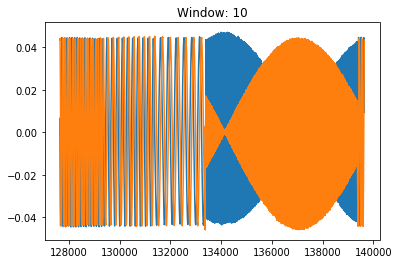

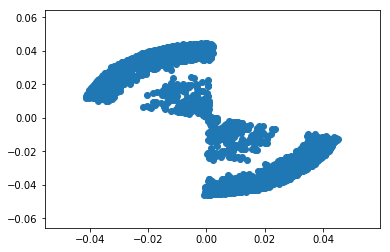

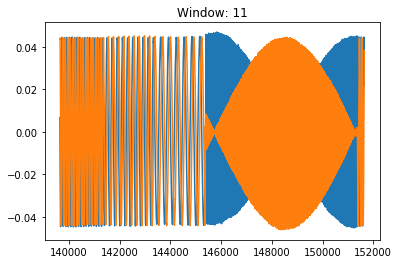

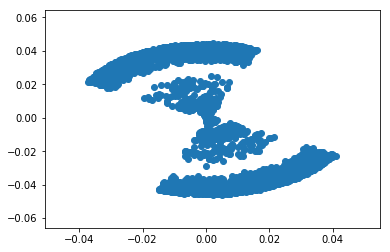

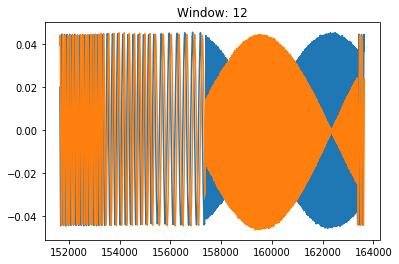

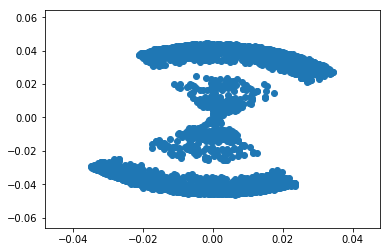

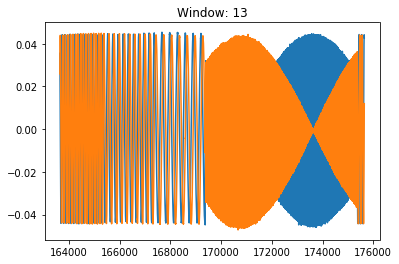

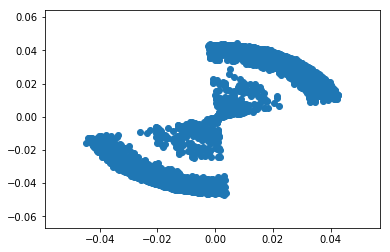

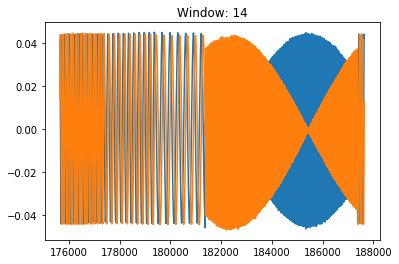

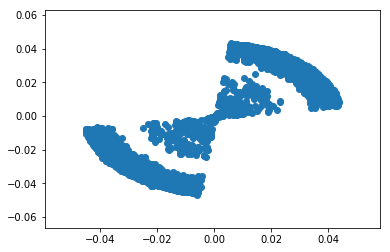

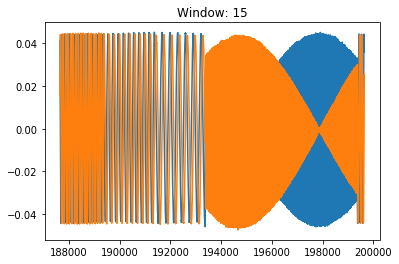

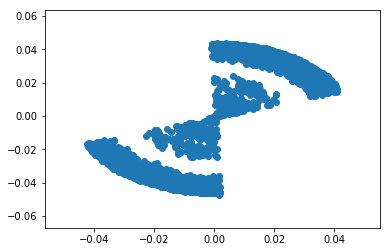

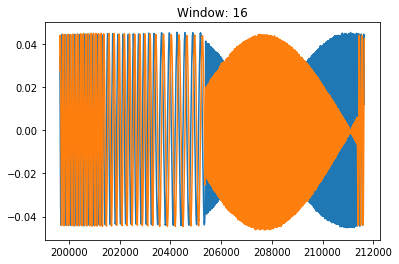

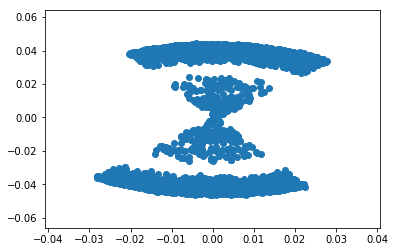

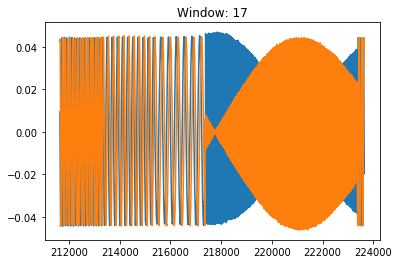

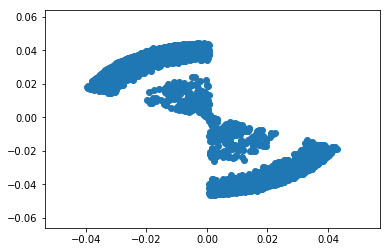

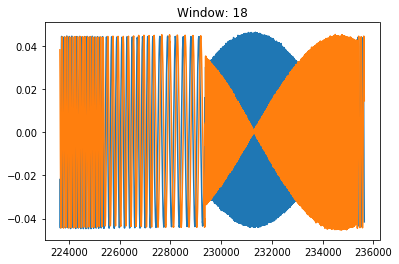

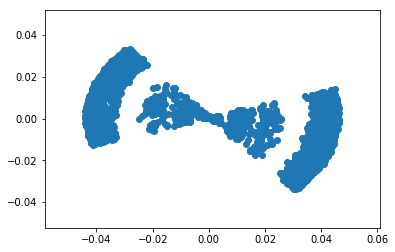

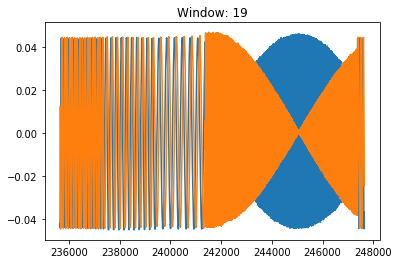

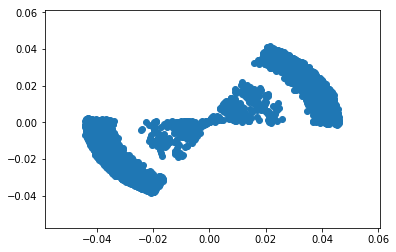

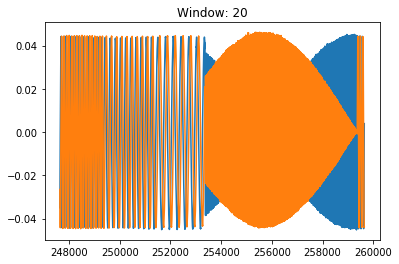

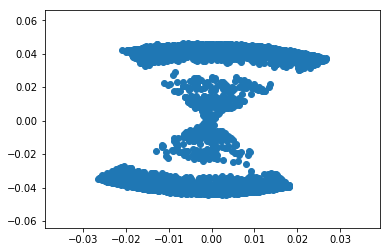

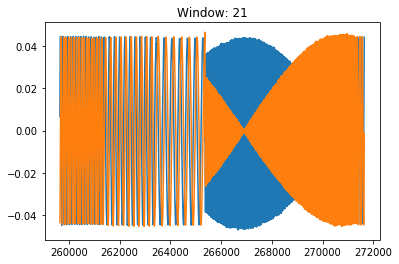

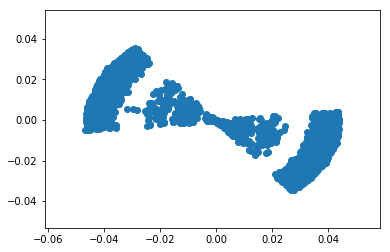

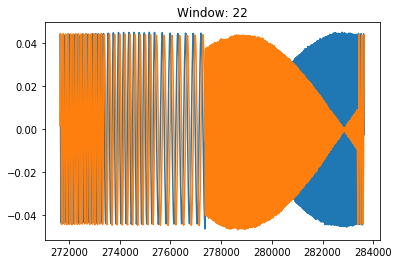

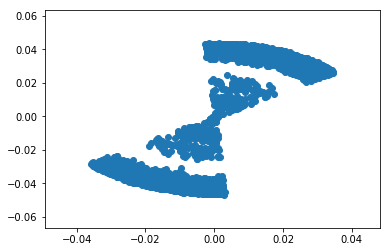

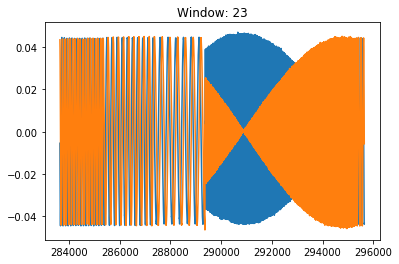

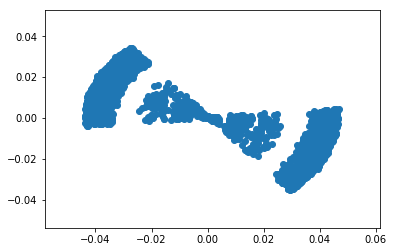

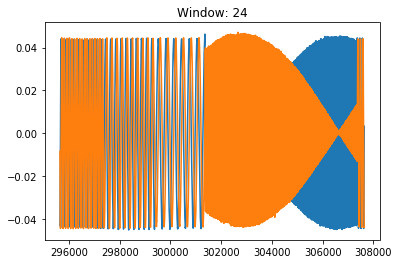

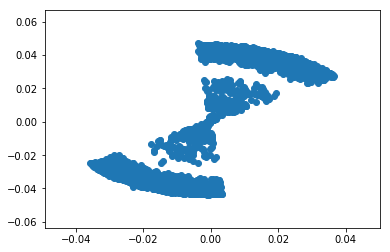

In [283]:
"""Cell:Test output segmentation"""
for idx in range(10,25):
    x = range(distorted_output_array[idx][0], distorted_output_array[idx][0] + len(distorted_output_array[idx][1]))
    plt.plot(x,distorted_output_array[idx][1].real)
    plt.plot(x,distorted_output_array[idx][1].imag)
    plt.title('Window: ' + str(idx))
    plt.show()
    
    complex_vector = distorted_output_array[idx][1]
    plt.scatter(complex_vector[7000:9500].real, complex_vector[7000:9500].imag)
    plt.show()
    


In [284]:
"""Cell:Correct carrier frequency offset"""

len_region = int(len_tone/3) #This controls how good carrier frequency offset is

def get_pure_tone_frequency(complex_vector, index, region):
    """Get frequency of the pure tone in a range of 'region', around 'index' in complex_vector"""
    
    tone_values = []
    for i in range(index - region//2, index + region//2):
        if i >= 0 and i < len(complex_vector):
            tone_values.append(complex_vector[i])
    
    predicted_freq_array = []
    for i in range(1,len(tone_values)):
        tone_ratio = tone_values[i]/tone_values[i-1]
        cur_predicted_freq = float(np.angle(tone_ratio)/(2*pi))
        predicted_freq_array.append(cur_predicted_freq)
    
#     print(predicted_freq_array)
    predicted_freq =  np.mean(predicted_freq_array)
    return predicted_freq

def get_carrier_frequency_offset(complex_vector, complex_input, region):
    """Returns the predicted carrier frequency offset"""   
    freq_diff_array = []
    for tone_frequency in tone_frequencies:
        input_freq = get_pure_tone_frequency(complex_input, index = int(correlation_dict[tone_frequency]['start'])+ len_tone//2, region = region)
        output_freq = get_pure_tone_frequency(complex_vector, index = int(correlation_dict[tone_frequency]['start']) + len_tone//2, region = region) 
        cur_freq_diff = output_freq - input_freq    
        freq_diff_array.append(cur_freq_diff)  
#         print(freq_diff_array)
    freq_diff = np.mean(freq_diff_array) 
    return freq_diff
    

def get_corrected_output_array(distorted_output_array):
    corrected_output_array = []
    for idx in range(len(distorted_output_array)):
        complex_vector = distorted_output_array[idx][1]
        freq_diff = get_carrier_frequency_offset(complex_vector, complex_input, region = len_region)

        #Generate the correcting wave
        x = np.arange(len(complex_vector))
        correcting_wave = np.exp(x*pi*(-2j)*freq_diff)

        corrected_y = [complex_vector[i]*correcting_wave[i] for i in range(len(correcting_wave))]
        corrected_y = np.array(corrected_y)

        corrected_output_array.append([freq_diff, corrected_y])
    
    return corrected_output_array


corrected_output_array = get_corrected_output_array(distorted_output_array)



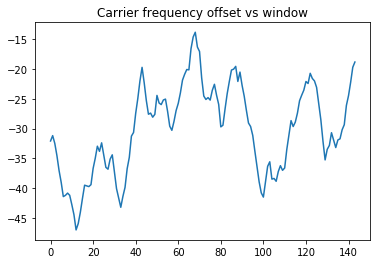

Segment: 70 Carrier frequency offset: -17.0179532049Hz,  Predicted period: 29380.7365657


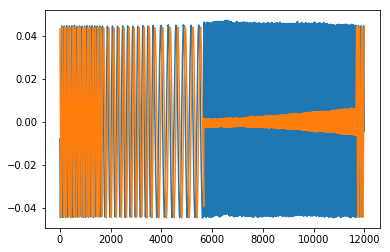

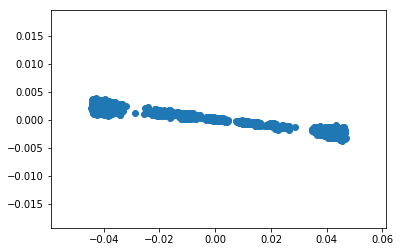

Segment: 71 Carrier frequency offset: -21.4545134893Hz,  Predicted period: 23305.1194682


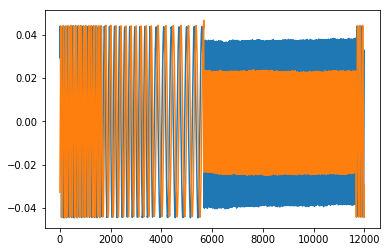

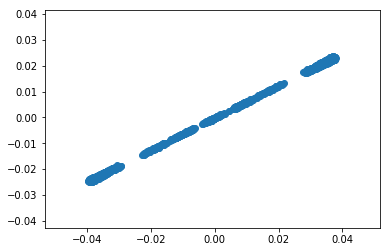

Segment: 72 Carrier frequency offset: -24.5168463937Hz,  Predicted period: 20394.1400933


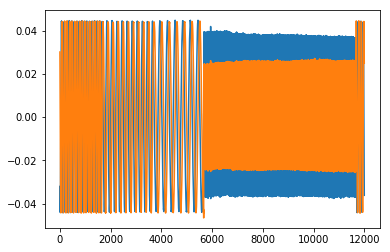

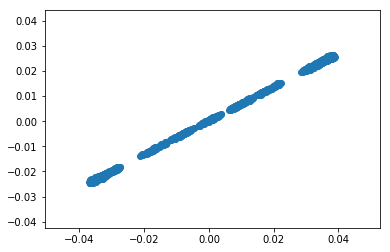

Segment: 73 Carrier frequency offset: -25.0902293313Hz,  Predicted period: 19928.0761207


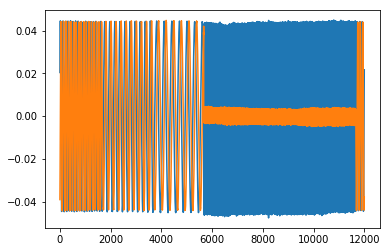

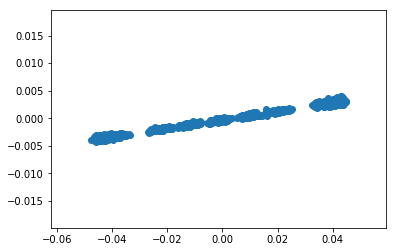

Segment: 74 Carrier frequency offset: -24.7783323917Hz,  Predicted period: 20178.920522


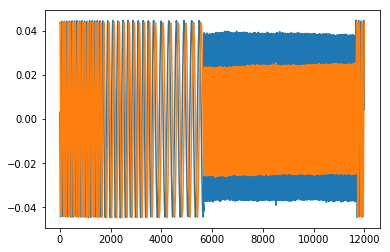

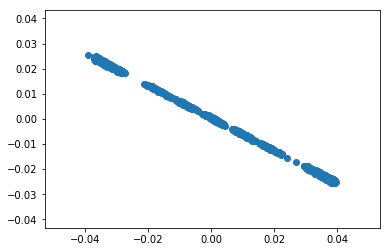

Segment: 75 Carrier frequency offset: -25.1938019862Hz,  Predicted period: 19846.1510603


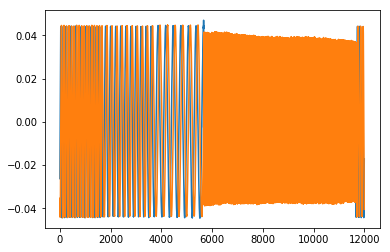

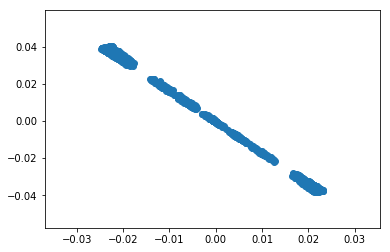

Segment: 76 Carrier frequency offset: -23.5525682499Hz,  Predicted period: 21229.1073608


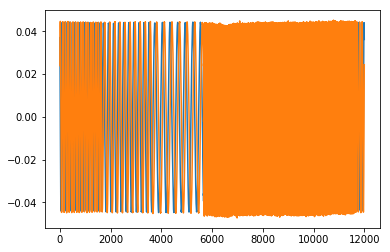

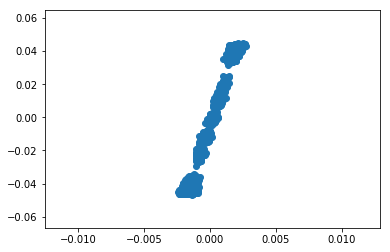

Segment: 77 Carrier frequency offset: -22.5379077211Hz,  Predicted period: 22184.8454695


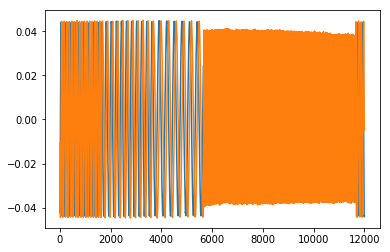

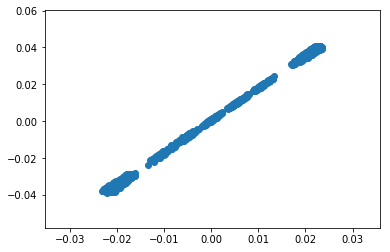

Segment: 78 Carrier frequency offset: -24.3741903436Hz,  Predicted period: 20513.5019031


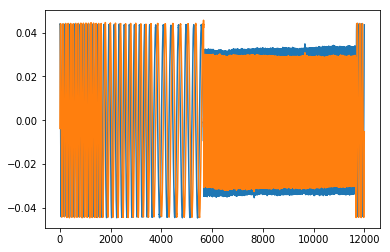

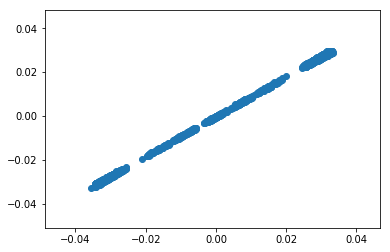

Segment: 79 Carrier frequency offset: -25.9240612222Hz,  Predicted period: 19287.1014967


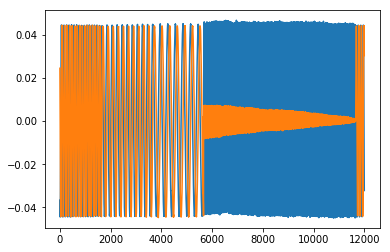

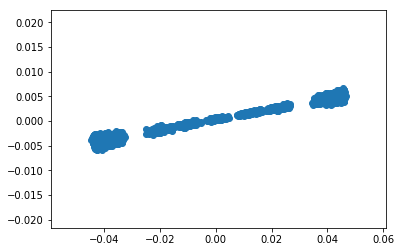

In [285]:
"""Cell:Test carrier frequency offset correction"""

carrier_freq_offset_array = [sampling_frequency*corrected_output_array[i][0] for i in range(len(corrected_output_array))]
plt.plot(carrier_freq_offset_array)
plt.title('Carrier frequency offset vs window')
plt.show()
# Main loop
for idx in range(70,80):
    complex_vector = corrected_output_array[idx][1]
    freq_diff = corrected_output_array[idx][0]
    print('Segment: ' + str(idx)+ ' Carrier frequency offset: ' + str(freq_diff*sampling_frequency) + 'Hz,  Predicted period: ' + str(1/abs(freq_diff)))
#     absOutput = max(abs(complex_vector[len_tone*len(tone_frequencies):]))
#     absInput =  max(abs(complex_input[len_tone*len(tone_frequencies):]))
#     absRatio = absOutput/absInput;
#     dbLoss = 20*np.log10(absRatio)
    
#     print(absOutput, absInput, absRatio, dbLoss)
                   
    
#     plt.plot(complex_vector.real/abs(max(complex_vector.real)))
#     plt.plot(correcting_wave.real/abs(max(correcting_wave.real)))   
#     plt.show()
    
# #     plt.plot(complex_vector.imag/abs(max(complex_vector.imag)))
# #     plt.plot(correcting_wave.imag/abs(max(correcting_wave.imag)))
# #     plt.show()
    

#     plt.show()
    
#     plt.plot(to_scale((complex_vector[3070:3170].real)))
#     plt.plot(to_scale((complex_vector[3070:3170].imag)))
    
#     plt.plot((np.angle(complex_vector[8070:8170])))
#     plt.plot(to_scale(abs(complex_input[8000:8100])))
    
    plt.plot(complex_vector.real)
    plt.plot(complex_vector.imag)
    plt.show()
    
    plt.scatter(complex_vector[7000:9500].real, complex_vector[7000:9500].imag)
    plt.show()

